In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import numpy as np
from solvers.OMISTL import OMISTL
import cvxpy as cp
from utils import *
import pickle, os
from MPC_prob import MPC

from tqdm import tqdm
from para import paraset
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'#不设这个解不出#

C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [36]:
N= 12
n_obs = 7
paraset(N=N, n_obs=n_obs,Qs=1,Rs=0,num_probs=20000,obs_default=False)

In [ ]:
#pass the value from config to dict and para
relative_path = os.getcwd()
dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
# dataset_name = 'NSTL_{}_horizon_{}'.format(Qs, N)
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

# config = [dataset_name, [prob_params] ,sampled_params]
outfile = open(config_fn,"rb")
config=pickle.load(outfile)
outfile.close()

train_fn = 'train_horizon_{}.p'.format(N)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
test_fn = 'test_horizon_{}.p'.format(N)
test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)

all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
            'posmin', 'posmax', 'velmin', 'velmax', \
            'umin', 'umax']

param_dict={}
i=0
len_para = len(all_params)
for param in all_params:
    param_dict[param]= config[1][i]
    i+=1
    if i == len_para:
        break

N = param_dict['N']
Ak = param_dict['Ak']
Bk = param_dict['Bk']
Q = param_dict['Q']
R = param_dict['R']
n_obs = param_dict['n_obs']
umin = param_dict['umin']
umax = param_dict['umax']
sampled_params = config[2]
n_obs = config[3]
num_probs = config[4]
border_size = config[5]
box_buffer = config[6]
min_box_size = config[7]
max_box_size = config[8]
posmin = config[9]
posmax = config[10]
velmin = config[11]
velmax = config[12]
n = config[13]
m= config[14]

obs_fix = config[15]
xg_fix = config[16]
if obs_fix:
    obstacles = config[-1]

config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')#

prob = MPC(config=config_fn)
#create numpy containers for data: (params, x, u, y, J*, solve_time)
params = {}
if 'x0' in sampled_params:
    params['x0'] = np.zeros((num_probs,2*n))
if 'xg' in sampled_params:
    params['xg'] = np.zeros((num_probs,2*n))
if 'obstacles' in sampled_params:
    params['obstacles'] = np.zeros((num_probs, 4, n_obs))

X = np.zeros((num_probs, 2*n, N));
U = np.zeros((num_probs, m, N-1))
Y = np.zeros((num_probs, 4*n_obs, N-1)).astype(int)
Z = np.zeros((num_probs, 2*n_obs, N-1)).astype(int)

costs = np.zeros(num_probs)
solve_times = np.zeros(num_probs)

prob.sampled_params = ['x0', 'xg', 'obstacles']

#solving MICP
ii_toggle = 0
obs_new_ct = 5
ii=0
obstacles = config[-1]

if obs_fix:
    for ii in tqdm(range(num_probs)):
        x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
        params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
        p_dict = {}
        params['x0'][ii,:] = x0
        xg= findIC(obstacles, posmin, posmax, velmin, velmax)
        params['xg'][ii,:] = xg

        p_dict['x0'] = params['x0'][ii,:]
        p_dict['xg'] = params['xg'][ii,:]
        p_dict['obstacles'] = params['obstacles'][ii,:]

        prob_success = False
        try:
            # with time_limit(20):
            prob_success, cost, solve_time, optvals = prob.solve_stl(p_dict, solver=cp.GUROBI)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('solver failed at '.format(ii))

        if prob_success:
            costs[ii] = cost; solve_times[ii] = solve_time
            X[ii,:,:], U[ii,:,:], Y[ii,:,:], Z[ii,:,:] = optvals
            ii += 1
else:
    print('choose to fix obstalce')

## shuffle the data because of the spatial orders
num_train = int(num_probs*0.9)
arr = np.arange(num_probs)
np.random.shuffle(arr)

if 'x0' in sampled_params:
    params['x0'] = params['x0'][arr]
if 'xg' in sampled_params:
    params['xg'] = params['xg'][arr]
if 'obstacles' in sampled_params:
    params['obstacles'] = params['obstacles'][arr]

costs = costs[arr]
solve_times = solve_times[arr]


X = X[arr]
U = U[arr]
Y = Y[arr]
Z = Z[arr]

train_params = {}; test_params = {}
if 'x0' in sampled_params:
    train_params['x0'] = params['x0'][:num_train,:]
    test_params['x0'] = params['x0'][num_train:,:]
if 'obstacles' in sampled_params:
    train_params['obstacles'] = params['obstacles'][:num_train,:]
    test_params['obstacles'] = params['obstacles'][num_train:,:]
if 'xg' in sampled_params:
    train_params['xg'] = params['xg'][:num_train,:]
    test_params['xg'] = params['xg'][num_train:,:]

train_data = [train_params]
train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:],Z[:num_train,:,:]]
train_data += [costs[:num_train], solve_times[:num_train]]

test_data = [test_params]
test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:], Z[:num_train,:,:]]
test_data += [costs[num_train:], solve_times[num_train:]]

train_file = open(train_fn,'wb')
pickle.dump(train_data,train_file); train_file.close()

test_file = open(test_fn, 'wb')
pickle.dump(test_data,test_file); test_file.close()

 72%|███████▏  | 14454/20000 [1:06:01<21:09,  4.37it/s]  

In [16]:
relative_path = os.getcwd()
dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
# dataset_name = 'NSTL_{}_horizon_{}'.format(Qs, N)
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
prob = MPC(config=config_fn) #use default config, pass different config file oth.

relative_path = os.getcwd()
dataset_fn = relative_path + '/data/' + dataset_name

##load train data
train_file = open(dataset_fn+'/train_horizon_{}.p'.format(N),'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
p_train, x_train, u_train, y_train, z_train, cost_train, times_train = train_data
train_file.close()

x_train = train_data[1] #X sequence
y_train = train_data[3] #Y sequence

##load test data
test_file = open(dataset_fn+'/test_horizon_{}.p'.format(N),'rb')
# test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test,z_test, cost_test,times_test = test_data
test_file.close()

In [17]:
# load results
f_read = open(dataset_fn+'/result.pkl', 'rb')
results = pickle.load(f_read)
f_read.close()
results['percentage']

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Curious\\OMISTL\\MPC/data/MPC_horizon_10_obs_10/result.pkl'

In [18]:
system = 'MPC'
prob_features = ['x0','xg','obstacles']
# prob_features = ['x0','obstacles_map']

MPC_obj = OMISTL(system, prob, prob_features)

n_features = 58
MPC_obj.construct_strategies(n_features, train_data)
print(MPC_obj.n_strategies)
print('n_obs: '+ str(n_obs))
print('N: '+ str(N))
MPC_obj.n_evals
MPC_obj.setup_network()

2871


In [7]:
fn_saved = 'D:\Curious\OMISTL\\models\\MPC_horizon_{}_obs_{}.pt'.format(N,n_obs)
MPC_obj.load_network(fn_saved)

No existing model!


In [8]:
MPC_obj.training_params['TRAINING_ITERATIONS'] = 500
MPC_obj.train(train_data=train_data, verbose=True)
MPC_obj.model

loss:   4.980214595794678,   acc:  0.3125
loss:   3.3978090286254883,   acc:  0.375
Done with epoch 0 in 13.799950361251831s
loss:   3.5012383460998535,   acc:  0.3125
loss:   3.7509822845458984,   acc:  0.25
loss:   2.687976360321045,   acc:  0.5
Done with epoch 1 in 11.445456981658936s
loss:   3.197068452835083,   acc:  0.40625
loss:   2.1897623538970947,   acc:  0.53125
loss:   3.0660879611968994,   acc:  0.375
Done with epoch 2 in 11.565070629119873s
loss:   2.972336769104004,   acc:  0.3125
loss:   2.8826279640197754,   acc:  0.3125
loss:   2.652818441390991,   acc:  0.3125
Done with epoch 3 in 11.672903776168823s
loss:   2.158147096633911,   acc:  0.4375
loss:   2.4542016983032227,   acc:  0.40625
loss:   1.9619592428207397,   acc:  0.53125
Done with epoch 4 in 11.845120668411255s
loss:   1.8364193439483643,   acc:  0.5625
loss:   2.380570650100708,   acc:  0.40625
Done with epoch 5 in 11.378574848175049s
loss:   2.058718681335449,   acc:  0.53125
loss:   1.6917544603347778,   ac

KeyboardInterrupt: 

In [9]:
outfile = open(config_fn,"rb")
config=pickle.load(outfile)
velmin = -0.2
velmax = 0.2
posmin = np.zeros(2)
n_obs = config[1][5]

ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])
max_box_size = 0.75
min_box_size = 0.25
box_buffer = 0.025
border_size = 0.05

obstacles = config[-1]


# x0 = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
# xg = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
x0 = [0.1,0.1,0,0]
xg = [3,0.5,0,0]

# obstacles = \
#         random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)
obstacles= config[-1]

prob_success = False
while not prob_success:
    prob_params = {}
    idx = np.random.randint(test_data[1].shape[0])
    for k in p_test.keys():
        prob_params[k] = p_test[k][idx]
    # prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    # prob_params['x0'] = x0
    # prob_params['xg'] = xg

    prob_success, cost, total_time, n_evals, optvals,y_guess = MPC_obj.forward(prob_params, solver=cp.GUROBI, max_evals=10)
    # prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(p_dict, solver=cp.GUROBI, max_evals=10)
    if prob_success:
        print('Found solution! ' + "n_evals = " + str(n_evals))
    else:
        print('Failed')
total_time

Academic license - for non-commercial use only - expires 2022-12-22
Using license file C:\Users\msi\gurobi.lic
Found solution! n_evals = 4


C:\Users\msi\anaconda3\envs\coco\lib\site-packages\cvxpy\problems\problem.py:1306: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


0.08100485801696777

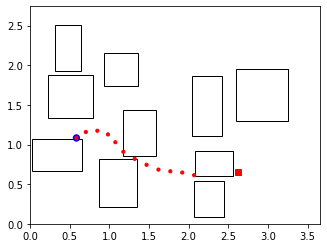

In [10]:
Xopt = optvals[0]

obstacles = []
for ii_obs in range(n_obs):
    obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='white', ec='black')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')


    xg = prob_params['xg']
    x0 = prob_params['x0']
    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="blue")
    plt.gca().add_patch(circle)

    #blue line is network prediction
    plt.plot(xg[0],xg[1],'sr')
    # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#plot using arrows
    for jj in range(N):
        circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='red',ec="red")
        plt.gca().add_patch(circle)


    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

In [11]:
n_test = 2000
framework = 'OMISTL'
n_succ = 0
count = 0
gurobi_fail = 0

costs = []
total_time_ML = []
num_solves = []

cost_ratios = []
costs_ip = []
total_time_ip = []

for ii in tqdm(range(n_test)):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals,y_guess = MPC_obj.forward(prob_params, max_evals=10, solver=cp.GUROBI)

        if prob_success:
            n_succ += 1
            costs += [cost]
            total_time_ML += [total_time]
            num_solves += [n_evals]

            true_cost = cost_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios += [cost / true_cost]
        count += 1
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        gurobi_fail += 1
        continue

costs = np.array(costs)
cost_ratios = np.array(cost_ratios)
total_time_ML = np.array(total_time_ML)
num_solves = np.array(num_solves, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)

percentage = 100 * float(n_succ) / float(count)
dict = {'framework':framework, 'costs':costs, 'total_time_ML':total_time_ML,'num_solves':num_solves, 'costs_ip':costs_ip, 'total_time_ip':total_time_ip, 'cost_ratios':cost_ratios,'percentage':percentage}
f_save = open(dataset_fn+'/result.pkl', 'wb')
pickle.dump(dict, f_save)
f_save.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

0 / 2000


  1%|          | 15/2000 [00:04<09:59,  3.31it/s]

Solver failed at 14


C:\Users\msi\anaconda3\envs\coco\lib\site-packages\cvxpy\problems\problem.py:1301: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
  1%|          | 17/2000 [00:04<08:42,  3.79it/s]

Solver failed at 15


  1%|          | 18/2000 [00:05<09:49,  3.36it/s]

Solver failed at 17


  1%|          | 22/2000 [00:05<07:18,  4.51it/s]

Solver failed at 20


  3%|▎         | 55/2000 [00:12<06:23,  5.07it/s]

Solver failed at 53


  6%|▌         | 110/2000 [00:23<06:51,  4.59it/s]

Solver failed at 109


  6%|▌         | 118/2000 [00:25<05:19,  5.89it/s]

Solver failed at 116


  8%|▊         | 157/2000 [00:33<05:45,  5.33it/s]

Solver failed at 155


  8%|▊         | 165/2000 [00:35<05:30,  5.55it/s]

Solver failed at 163


  9%|▉         | 175/2000 [00:37<06:18,  4.82it/s]

Solver failed at 173


 12%|█▏        | 238/2000 [00:49<05:57,  4.93it/s]

Solver failed at 237


 12%|█▏        | 245/2000 [00:50<06:01,  4.85it/s]

Solver failed at 244


 13%|█▎        | 257/2000 [00:53<05:07,  5.67it/s]

Solver failed at 256


 15%|█▌        | 308/2000 [01:03<06:18,  4.47it/s]

Solver failed at 306


 16%|█▌        | 315/2000 [01:04<04:45,  5.90it/s]

Solver failed at 313


 16%|█▌        | 323/2000 [01:05<04:43,  5.91it/s]

Solver failed at 322


 17%|█▋        | 340/2000 [01:08<03:54,  7.07it/s]

Solver failed at 338


 19%|█▉        | 384/2000 [01:16<05:24,  4.99it/s]

Solver failed at 383


 20%|█▉        | 391/2000 [01:17<04:22,  6.13it/s]

Solver failed at 389


 20%|██        | 405/2000 [01:20<06:27,  4.12it/s]

Solver failed at 404


 21%|██        | 418/2000 [01:23<05:30,  4.78it/s]

Solver failed at 417


 22%|██▏       | 430/2000 [01:25<03:35,  7.28it/s]

Solver failed at 428


 22%|██▎       | 450/2000 [01:28<03:50,  6.71it/s]

Solver failed at 448


 23%|██▎       | 455/2000 [01:29<03:34,  7.19it/s]

Solver failed at 453


 23%|██▎       | 465/2000 [01:31<05:26,  4.71it/s]

Solver failed at 465


 24%|██▎       | 473/2000 [01:32<04:25,  5.76it/s]

Solver failed at 472


 24%|██▍       | 488/2000 [01:35<04:04,  6.18it/s]

Solver failed at 487


 25%|██▌       | 505/2000 [01:38<03:58,  6.27it/s]

Solver failed at 503


 27%|██▋       | 546/2000 [01:45<03:39,  6.63it/s]

Solver failed at 544


 28%|██▊       | 550/2000 [01:46<03:13,  7.50it/s]

Solver failed at 548


 28%|██▊       | 555/2000 [01:47<04:40,  5.15it/s]

Solver failed at 554


 29%|██▉       | 584/2000 [01:52<03:46,  6.25it/s]

Solver failed at 582


 29%|██▉       | 587/2000 [01:52<04:24,  5.34it/s]

Solver failed at 585


 30%|██▉       | 598/2000 [01:55<04:03,  5.76it/s]

Solver failed at 596


 30%|███       | 610/2000 [01:57<04:17,  5.40it/s]

Solver failed at 608


 31%|███       | 623/2000 [01:58<02:44,  8.40it/s]

Solver failed at 622


 35%|███▍      | 694/2000 [02:11<03:42,  5.88it/s]

Solver failed at 694


 35%|███▌      | 708/2000 [02:13<03:18,  6.52it/s]

Solver failed at 706


 37%|███▋      | 746/2000 [02:19<03:14,  6.46it/s]

Solver failed at 745


 38%|███▊      | 760/2000 [02:21<03:40,  5.63it/s]

Solver failed at 759


 39%|███▊      | 772/2000 [02:23<02:17,  8.95it/s]

Solver failed at 770


 41%|████      | 811/2000 [02:29<03:18,  6.00it/s]

Solver failed at 809


 41%|████      | 820/2000 [02:30<02:51,  6.89it/s]

Solver failed at 818


 43%|████▎     | 854/2000 [02:36<02:21,  8.09it/s]

Solver failed at 852


 44%|████▎     | 870/2000 [02:38<03:08,  5.98it/s]

Solver failed at 870


 44%|████▍     | 890/2000 [02:41<02:59,  6.18it/s]

Solver failed at 888


 46%|████▋     | 925/2000 [02:46<03:28,  5.15it/s]

Solver failed at 923


 49%|████▉     | 979/2000 [02:55<02:36,  6.52it/s]

Solver failed at 977


 49%|████▉     | 985/2000 [02:56<02:11,  7.74it/s]

Solver failed at 983


 50%|████▉     | 993/2000 [02:57<02:28,  6.79it/s]

Solver failed at 991


 50%|█████     | 1001/2000 [02:58<01:59,  8.39it/s]

1000 / 2000


 51%|█████     | 1022/2000 [03:01<02:04,  7.83it/s]

Solver failed at 1020
Solver failed at 1021


 51%|█████▏    | 1025/2000 [03:01<02:24,  6.74it/s]

Solver failed at 1023


 53%|█████▎    | 1054/2000 [03:06<02:22,  6.63it/s]

Solver failed at 1054


 53%|█████▎    | 1069/2000 [03:09<02:30,  6.18it/s]

Solver failed at 1067


 55%|█████▌    | 1100/2000 [03:14<02:39,  5.65it/s]

Solver failed at 1099


 56%|█████▌    | 1118/2000 [03:18<02:53,  5.08it/s]

Solver failed at 1117


 56%|█████▋    | 1125/2000 [03:19<02:12,  6.62it/s]

Solver failed at 1123


 56%|█████▋    | 1129/2000 [03:20<02:54,  5.00it/s]

Solver failed at 1128


 57%|█████▋    | 1136/2000 [03:21<02:27,  5.87it/s]

Solver failed at 1134


 58%|█████▊    | 1151/2000 [03:24<02:18,  6.14it/s]

Solver failed at 1149


 59%|█████▉    | 1180/2000 [03:29<02:38,  5.17it/s]

Solver failed at 1179


 59%|█████▉    | 1185/2000 [03:30<02:02,  6.63it/s]

Solver failed at 1184


 60%|█████▉    | 1191/2000 [03:31<01:49,  7.40it/s]

Solver failed at 1189


 60%|██████    | 1202/2000 [03:32<01:40,  7.95it/s]

Solver failed at 1200


 61%|██████    | 1223/2000 [03:36<02:42,  4.79it/s]

Solver failed at 1222
Solver failed at 1223


 62%|██████▎   | 1250/2000 [03:41<01:58,  6.32it/s]

Solver failed at 1248


 63%|██████▎   | 1256/2000 [03:42<02:17,  5.40it/s]

Solver failed at 1254


 65%|██████▌   | 1300/2000 [03:50<02:22,  4.90it/s]

Solver failed at 1299


 66%|██████▌   | 1317/2000 [03:53<01:51,  6.12it/s]

Solver failed at 1315


 66%|██████▋   | 1329/2000 [03:56<02:04,  5.37it/s]

Solver failed at 1328


 69%|██████▊   | 1371/2000 [04:03<01:43,  6.10it/s]

Solver failed at 1370


 69%|██████▉   | 1376/2000 [04:04<02:02,  5.09it/s]

Solver failed at 1374


 69%|██████▉   | 1377/2000 [04:04<02:13,  4.67it/s]

Solver failed at 1376


 70%|███████   | 1410/2000 [04:10<01:51,  5.29it/s]

Solver failed at 1410


 72%|███████▏  | 1439/2000 [04:15<01:15,  7.48it/s]

Solver failed at 1437


 74%|███████▎  | 1474/2000 [04:22<01:50,  4.76it/s]

Solver failed at 1474


 74%|███████▍  | 1479/2000 [04:23<01:46,  4.88it/s]

Solver failed at 1478


 76%|███████▋  | 1528/2000 [04:31<01:18,  6.01it/s]

Solver failed at 1526


 78%|███████▊  | 1550/2000 [04:34<01:13,  6.14it/s]

Solver failed at 1548


 78%|███████▊  | 1565/2000 [04:36<00:57,  7.63it/s]

Solver failed at 1563


 81%|████████  | 1619/2000 [04:47<01:15,  5.06it/s]

Solver failed at 1617


 82%|████████▏ | 1634/2000 [04:50<01:05,  5.60it/s]

Solver failed at 1632


 82%|████████▏ | 1647/2000 [04:52<01:03,  5.53it/s]

Solver failed at 1645


 83%|████████▎ | 1652/2000 [04:53<00:56,  6.20it/s]

Solver failed at 1651


 83%|████████▎ | 1656/2000 [04:54<01:27,  3.93it/s]

Solver failed at 1655


 83%|████████▎ | 1665/2000 [04:56<01:04,  5.17it/s]

Solver failed at 1663


 84%|████████▎ | 1673/2000 [04:57<00:50,  6.49it/s]

Solver failed at 1671


 85%|████████▌ | 1708/2000 [05:04<00:46,  6.31it/s]

Solver failed at 1706


 88%|████████▊ | 1759/2000 [05:14<00:48,  4.96it/s]

Solver failed at 1757


 89%|████████▊ | 1771/2000 [05:16<00:30,  7.42it/s]

Solver failed at 1769


 89%|████████▉ | 1775/2000 [05:17<00:48,  4.67it/s]

Solver failed at 1774


 90%|████████▉ | 1794/2000 [05:20<00:28,  7.28it/s]

Solver failed at 1792


 90%|█████████ | 1803/2000 [05:22<00:29,  6.60it/s]

Solver failed at 1801


 90%|█████████ | 1806/2000 [05:22<00:30,  6.31it/s]

Solver failed at 1804


 90%|█████████ | 1807/2000 [05:22<00:34,  5.67it/s]

Solver failed at 1806


 91%|█████████ | 1818/2000 [05:24<00:26,  6.86it/s]

Solver failed at 1816


 91%|█████████ | 1820/2000 [05:25<00:23,  7.81it/s]

Solver failed at 1818


 93%|█████████▎| 1860/2000 [05:32<00:23,  6.01it/s]

Solver failed at 1858


 93%|█████████▎| 1867/2000 [05:33<00:27,  4.76it/s]

Solver failed at 1865


 93%|█████████▎| 1869/2000 [05:34<00:28,  4.67it/s]

Solver failed at 1868


 94%|█████████▎| 1872/2000 [05:34<00:28,  4.46it/s]

Solver failed at 1872


 94%|█████████▍| 1886/2000 [05:37<00:16,  6.94it/s]

Solver failed at 1884


 94%|█████████▍| 1889/2000 [05:37<00:17,  6.41it/s]

Solver failed at 1888
Solver failed at 1889


 95%|█████████▍| 1897/2000 [05:38<00:15,  6.44it/s]

Solver failed at 1895


 95%|█████████▌| 1901/2000 [05:39<00:17,  5.55it/s]

Solver failed at 1900


 95%|█████████▌| 1908/2000 [05:40<00:14,  6.23it/s]

Solver failed at 1906


 96%|█████████▌| 1910/2000 [05:41<00:17,  5.29it/s]

Solver failed at 1908


 96%|█████████▌| 1918/2000 [05:42<00:14,  5.53it/s]

Solver failed at 1916


 96%|█████████▋| 1929/2000 [05:45<00:12,  5.91it/s]

Solver failed at 1927


 98%|█████████▊| 1959/2000 [05:50<00:07,  5.13it/s]

Solver failed at 1958


 99%|█████████▊| 1972/2000 [05:52<00:05,  5.33it/s]

Solver failed at 1972


100%|██████████| 2000/2000 [05:58<00:00,  5.58it/s]


In [86]:
# N = 8
# n_obs = 10
# dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
# config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
# relative_path = os.getcwd()
# dataset_fn = relative_path + '/data/' + dataset_name

In [13]:
# load results
f_read = open(dataset_fn+'/result.pkl', 'rb')
results = pickle.load(f_read)
f_read.close()
results

{'framework': 'OMISTL',
 'costs': array([ 48.36645753,  30.11328263, 196.43579083, ...,  69.75929735,
          4.11790463,  54.26471937]),
 'total_time_ML': array([0.03499389, 0.03701115, 0.08699226, ..., 0.03199697, 0.0190053 ,
        0.04399443]),
 'num_solves': array([1, 1, 9, ..., 1, 1, 2]),
 'costs_ip': array([ 47.852325  ,  29.40241565, 195.98101193, ...,  68.16903568,
          4.11790415,  53.95031834]),
 'total_time_ip': array([0.13127327, 0.23078728, 0.62501335, ..., 1.32827759, 0.15625381,
        0.20329285]),
 'cost_ratios': array([1.01074415, 1.02417716, 1.00232053, ..., 1.02332821, 1.00000012,
        1.0058276 ]),
 'percentage': 73.5949098621421}

In [88]:
from test_results import test_strategy
test_strategy(7,n_obs=5)

  0%|          | 60/20000 [00:05<30:51, 10.77it/s] 


KeyboardInterrupt: 

In [ ]:
test_strategy(7,n_obs=5)

In [144]:
percent_successes = {}
percent_successes[6] = {6: 0.928, 7: 0.904, 8: 0.92, 9: 0.86, 10: 0.848, 11: 0.85, 12: 0.858},
percent_successes[7] = {6: 0.894, 7: 0.902, 8: 0.886, 9: 0.866, 10: 0.822, 11: 0.802, 12: 0.814},
percent_successes[8] = {6: 0.856, 7: 0.864, 8: 0.806, 9: 0.79, 10: 0.768, 11: 0.724, 12: 0.742},
percent_successes[9] = {6: 0.868, 7: 0.818, 8: 0.82, 9: 0.814, 10: 0.77, 11: 0.764, 12: 0.748},
percent_successes[10] = {6: 0.806, 7: 0.802, 8: 0.726, 9: 0.736, 10: 0.718, 11: 0.628, 12: 0.652},
percent_successes[11] = {6: 0.774, 7: 0.748, 8: 0.744, 9: 0.684, 10: 0.616, 11: 0.592, 12: 0.608}
percent_successes[12] = {6: 0.708, 7: 0.666, 8: 0.614, 9: 0.622, 10: 0.61, 11: 0.564, 12: 0.498}

In [165]:
percent_successes = [
    [0.928, 0.904, 0.92, 0.86, 0.848, 0.85, 0.858],
    [0.928, 0.904, 0.92, 0.86, 0.848, 0.85, 0.858],
    [0.928, 0.904, 0.92, 0.86, 0.848, 0.85, 0.858],
    [0.928, 0.904, 0.92, 0.86, 0.848, 0.85, 0.858],
    [0.928, 0.904, 0.92, 0.86, 0.848, 0.85, 0.858],
    [0.928, 0.904, 0.92, 0.86, 0.848, 0.85, 0.858],
    [0.928, 0.904, 0.92, 0.86, 0.848, 0.85, 0.858]
]

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set(font_scale=1.5, font="serif", style="whitegrid")
import pandas as pd

flierprops = {'alpha':0.2}
sns.set(rc={'figure.figsize':(11.7,8.27)})

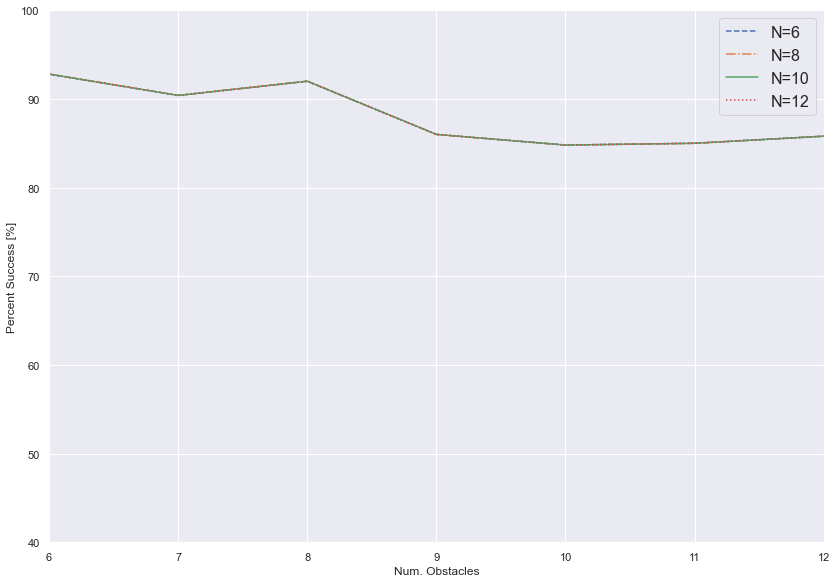

In [184]:

linestyles = ['--', '-.', '-', ':']

plot_horizons = [6,8,10,12]
for ii, N in enumerate(plot_horizons):
    batch_percent_success = percent_successes[ii]
    xlabels = [ii for ii in range(0,7)]
    x_labels = [ii for ii in range(6,13)]
    y_labels = [100.*batch_percent_success[x] for x in xlabels]
    ax1 = sns.lineplot(x=x_labels, y=y_labels, palette="Set3", label='N={}'.format(N), linewidth=1.5)
    ax1.lines[ii].set_linestyle(linestyles[ii])
    # ax1.set(xlabel="", ylabel="Percent Success")

ax1.set(xlabel="Num. Obstacles", ylabel="Percent Success [%]")
# ax1.grid(False)

yticks =  [10*ii for ii in range(11)]
ax1.set_yticks(yticks)

#
plt.tight_layout()
plt.legend(loc='upper right', fontsize='16')
plt.xlim([6,12])
plt.ylim([40.,100.])

# sns.set_style("whitegrid")
st = sns.axes_style("whitegrid")
sns.set_color_codes("dark")

figure = ax1.get_figure()
# figure.savefig("percent_success_generalization.pdf")